##Getting Started

In [12]:
!pip install --q wandb==0.15.7
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.2 MB/s eta 0:00:00


In [13]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

In [3]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [14]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

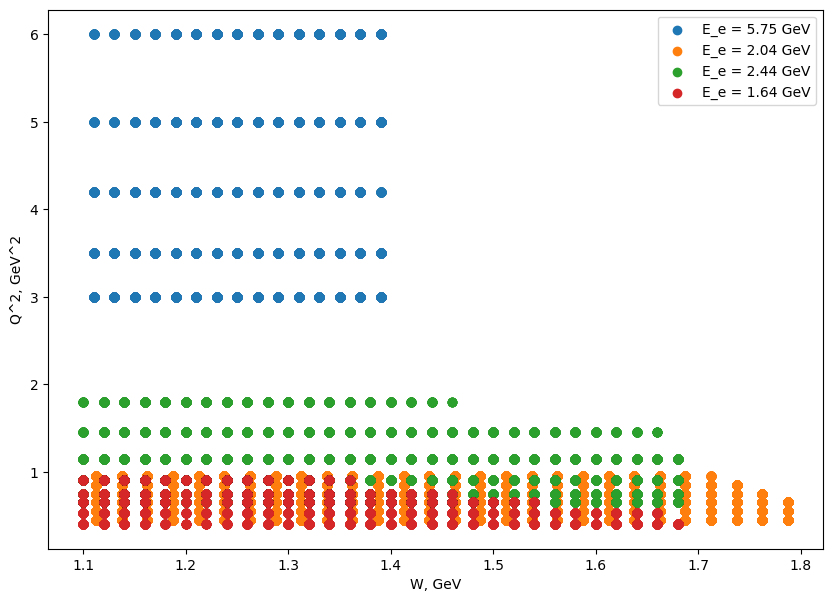

In [15]:
plt.rcParams["figure.figsize"] = (10,7)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [16]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.sqrt(torch.mean((x - y)**2))
        return criterion

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': False,
    'feature_scaler': StandardScaler(),   #Standard and MinMax are pretty good
    'label_scaler': StandardScaler(),
    'augment': False,
    'augment_factor': 20,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': RMSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 50,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        print("df_feature", df_feature)
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]
        #df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            augment_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(augment_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_df = pd.concat([augment_df, aug_df], ignore_index=True)
            train_label_data = augment_df["dsigma_dOmega"]
            train_feature_data = augment_df.loc[:, ~augment_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

wandb: Currently logged in as: chistiakova-vv19 (nucl_clas). Use `wandb login --relogin` to force relogin


In [17]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator='gpu',
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: True (cuda), used: True


2024-12-03 18:12:40,960 : INFO : GPU available: True (cuda), used: True


INFO: TPU available: False, using: 0 TPU cores


2024-12-03 18:12:40,964 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-03 18:12:40,968 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-03 18:12:40,977 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2024-12-03 18:12:41,175 : INFO : LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2024-12-03 18:12:41,216 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2024-12-03 18:12:41,395 : INFO : Training is starting
2024-12-03 18:12:46,191 : INFO : epoch: 0; val_loss: 3.1795690059661865
2024-

INFO: Metric val_loss improved. New best score: 3.180


2024-12-03 18:12:46,229 : INFO : Metric val_loss improved. New best score: 3.180
2024-12-03 18:12:46,461 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=3.17957-epoch=00.ckpt
2024-12-03 18:12:52,627 : INFO : epoch: 1; val_loss: 2.6939120292663574
2024-12-03 18:12:52,644 : INFO : epoch: 1; train_loss: 2.7814643383026123


INFO: Metric val_loss improved by 0.486 >= min_delta = 1e-05. New best score: 2.694


2024-12-03 18:12:52,675 : INFO : Metric val_loss improved by 0.486 >= min_delta = 1e-05. New best score: 2.694
2024-12-03 18:12:52,987 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=2.69391-epoch=01.ckpt
2024-12-03 18:12:58,684 : INFO : epoch: 2; val_loss: 1.614370346069336
2024-12-03 18:12:58,697 : INFO : epoch: 2; train_loss: 2.134598731994629


INFO: Metric val_loss improved by 1.080 >= min_delta = 1e-05. New best score: 1.614


2024-12-03 18:12:58,720 : INFO : Metric val_loss improved by 1.080 >= min_delta = 1e-05. New best score: 1.614
2024-12-03 18:12:58,945 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.61437-epoch=02.ckpt
2024-12-03 18:13:07,692 : INFO : epoch: 3; val_loss: 1.6300281286239624
2024-12-03 18:13:07,713 : INFO : epoch: 3; train_loss: 1.738955020904541
2024-12-03 18:13:08,335 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.63003-epoch=03.ckpt
2024-12-03 18:13:14,186 : INFO : epoch: 4; val_loss: 1.8835312128067017
2024-12-03 18:13:14,197 : INFO : epoch: 4; train_loss: 1.6588085889816284
2024-12-03 18:13:14,437 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.88353-epoch=04.ckpt
2024-12-03 18:13:19,687 : INFO : epoch: 5; val_loss: 1.677054166

INFO: Metric val_loss improved by 0.319 >= min_delta = 1e-05. New best score: 1.296


2024-12-03 18:13:31,709 : INFO : Metric val_loss improved by 0.319 >= min_delta = 1e-05. New best score: 1.296
2024-12-03 18:13:31,926 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.29576-epoch=07.ckpt
2024-12-03 18:13:38,522 : INFO : epoch: 8; val_loss: 1.1758912801742554
2024-12-03 18:13:38,534 : INFO : epoch: 8; train_loss: 1.3301256895065308


INFO: Metric val_loss improved by 0.120 >= min_delta = 1e-05. New best score: 1.176


2024-12-03 18:13:38,560 : INFO : Metric val_loss improved by 0.120 >= min_delta = 1e-05. New best score: 1.176
2024-12-03 18:13:38,778 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.17589-epoch=08.ckpt
2024-12-03 18:13:44,889 : INFO : epoch: 9; val_loss: 1.31998610496521
2024-12-03 18:13:44,942 : INFO : epoch: 9; train_loss: 1.319453477859497
2024-12-03 18:13:45,466 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.31999-epoch=09.ckpt
2024-12-03 18:13:52,574 : INFO : epoch: 10; val_loss: 1.270998239517212
2024-12-03 18:13:52,590 : INFO : epoch: 10; train_loss: 1.3013176918029785
2024-12-03 18:13:52,838 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.27100-epoch=10.ckpt
2024-12-03 18:13:58,101 : INFO : epoch: 11; val_loss: 1.698284864

INFO: Metric val_loss improved by 0.019 >= min_delta = 1e-05. New best score: 1.157


2024-12-03 18:14:39,712 : INFO : Metric val_loss improved by 0.019 >= min_delta = 1e-05. New best score: 1.157
2024-12-03 18:14:39,958 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.15654-epoch=18.ckpt
2024-12-03 18:14:45,872 : INFO : epoch: 19; val_loss: 1.217471718788147
2024-12-03 18:14:45,886 : INFO : epoch: 19; train_loss: 1.2506518363952637
2024-12-03 18:14:46,194 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.21747-epoch=19.ckpt
2024-12-03 18:14:52,168 : INFO : epoch: 20; val_loss: 1.127917766571045
2024-12-03 18:14:52,183 : INFO : epoch: 20; train_loss: 1.249238133430481


INFO: Metric val_loss improved by 0.029 >= min_delta = 1e-05. New best score: 1.128


2024-12-03 18:14:52,210 : INFO : Metric val_loss improved by 0.029 >= min_delta = 1e-05. New best score: 1.128
2024-12-03 18:14:52,432 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.12792-epoch=20.ckpt
2024-12-03 18:14:57,654 : INFO : epoch: 21; val_loss: 1.1588149070739746
2024-12-03 18:14:57,665 : INFO : epoch: 21; train_loss: 1.250579595565796
2024-12-03 18:14:57,916 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.15881-epoch=21.ckpt
2024-12-03 18:15:04,476 : INFO : epoch: 22; val_loss: 1.2056818008422852
2024-12-03 18:15:04,489 : INFO : epoch: 22; train_loss: 1.2359615564346313
2024-12-03 18:15:09,742 : INFO : epoch: 23; val_loss: 1.3255259990692139
2024-12-03 18:15:09,758 : INFO : epoch: 23; train_loss: 1.231997013092041
2024-12-03 18:15:16,327 : INFO : epoch: 24; val_loss: 1.4694318771362305
2024-12-03 18:15:1

INFO: Metric val_loss improved by 0.021 >= min_delta = 1e-05. New best score: 1.107


2024-12-03 18:15:21,542 : INFO : Metric val_loss improved by 0.021 >= min_delta = 1e-05. New best score: 1.107
2024-12-03 18:15:21,771 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.10700-epoch=25.ckpt
2024-12-03 18:15:27,675 : INFO : epoch: 26; val_loss: 1.1266636848449707
2024-12-03 18:15:27,691 : INFO : epoch: 26; train_loss: 1.164122462272644
2024-12-03 18:15:28,013 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.12666-epoch=26.ckpt
2024-12-03 18:15:33,847 : INFO : epoch: 27; val_loss: 1.1534708738327026
2024-12-03 18:15:33,860 : INFO : epoch: 27; train_loss: 1.1812841892242432
2024-12-03 18:15:39,010 : INFO : epoch: 28; val_loss: 1.08644700050354
2024-12-03 18:15:39,022 : INFO : epoch: 28; train_loss: 1.1688520908355713


INFO: Metric val_loss improved by 0.021 >= min_delta = 1e-05. New best score: 1.086


2024-12-03 18:15:39,048 : INFO : Metric val_loss improved by 0.021 >= min_delta = 1e-05. New best score: 1.086
2024-12-03 18:15:39,274 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.08645-epoch=28.ckpt
2024-12-03 18:15:45,992 : INFO : epoch: 29; val_loss: 1.1462503671646118
2024-12-03 18:15:46,005 : INFO : epoch: 29; train_loss: 1.170459508895874
2024-12-03 18:15:51,205 : INFO : epoch: 30; val_loss: 1.166324496269226
2024-12-03 18:15:51,220 : INFO : epoch: 30; train_loss: 1.1736996173858643
2024-12-03 18:15:57,598 : INFO : epoch: 31; val_loss: 1.0987677574157715
2024-12-03 18:15:57,612 : INFO : epoch: 31; train_loss: 1.1748030185699463
2024-12-03 18:15:57,858 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.09877-epoch=31.ckpt
2024-12-03 18:16:03,130 : INFO : epoch: 32; val_loss: 1.2948417663574219
2024-12-03 18:16:0

INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.083


2024-12-03 18:16:15,190 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.083
2024-12-03 18:16:15,421 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.08320-epoch=34.ckpt
2024-12-03 18:16:20,689 : INFO : epoch: 35; val_loss: 1.0805209875106812
2024-12-03 18:16:20,702 : INFO : epoch: 35; train_loss: 1.1669753789901733


INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.081


2024-12-03 18:16:20,728 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.081
2024-12-03 18:16:20,955 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.08052-epoch=35.ckpt
2024-12-03 18:16:28,277 : INFO : epoch: 36; val_loss: 1.1288397312164307
2024-12-03 18:16:28,293 : INFO : epoch: 36; train_loss: 1.1636234521865845
2024-12-03 18:16:33,975 : INFO : epoch: 37; val_loss: 1.1279441118240356
2024-12-03 18:16:33,988 : INFO : epoch: 37; train_loss: 1.1588791608810425
2024-12-03 18:16:40,409 : INFO : epoch: 38; val_loss: 1.0861200094223022
2024-12-03 18:16:40,422 : INFO : epoch: 38; train_loss: 1.158206820487976
2024-12-03 18:16:40,667 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.08612-epoch=38.ckpt
2024-12-03 18:16:45,981 : INFO : epoch: 39; val_loss: 1.1981916427612305
2024-12-03 18:16:

INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.077


2024-12-03 18:16:57,529 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.077
2024-12-03 18:16:57,756 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.07736-epoch=41.ckpt
2024-12-03 18:17:03,173 : INFO : epoch: 42; val_loss: 1.0948317050933838
2024-12-03 18:17:03,189 : INFO : epoch: 42; train_loss: 1.122287392616272
2024-12-03 18:17:09,447 : INFO : epoch: 43; val_loss: 1.045635461807251
2024-12-03 18:17:09,461 : INFO : epoch: 43; train_loss: 1.1300462484359741


INFO: Metric val_loss improved by 0.032 >= min_delta = 1e-05. New best score: 1.046


2024-12-03 18:17:09,488 : INFO : Metric val_loss improved by 0.032 >= min_delta = 1e-05. New best score: 1.046
2024-12-03 18:17:09,722 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.04564-epoch=43.ckpt
2024-12-03 18:17:15,074 : INFO : epoch: 44; val_loss: 1.0469181537628174
2024-12-03 18:17:15,088 : INFO : epoch: 44; train_loss: 1.1256053447723389
2024-12-03 18:17:15,338 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.04692-epoch=44.ckpt
2024-12-03 18:17:21,857 : INFO : epoch: 45; val_loss: 1.0581960678100586
2024-12-03 18:17:21,871 : INFO : epoch: 45; train_loss: 1.119521975517273
2024-12-03 18:17:22,119 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.05820-epoch=45.ckpt
2024-12-03 18:17:27,410 : INFO : epoch: 46; val_loss: 1.0809

INFO: Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 1.039


2024-12-03 18:19:13,191 : INFO : Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 1.039
2024-12-03 18:19:13,417 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.03898-epoch=64.ckpt
2024-12-03 18:19:18,649 : INFO : epoch: 65; val_loss: 1.0536043643951416
2024-12-03 18:19:18,660 : INFO : epoch: 65; train_loss: 1.097960114479065
2024-12-03 18:19:24,512 : INFO : epoch: 66; val_loss: 1.0409291982650757
2024-12-03 18:19:24,543 : INFO : epoch: 66; train_loss: 1.093921422958374
2024-12-03 18:19:24,776 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.04093-epoch=66.ckpt
2024-12-03 18:19:30,644 : INFO : epoch: 67; val_loss: 1.0582243204116821
2024-12-03 18:19:30,656 : INFO : epoch: 67; train_loss: 1.0930097103118896
2024-12-03 18:19:35,797 : INFO : epoch: 68; val_loss: 1.0724618434906006
2024-12-03 18:19:3

INFO: Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 1.035


2024-12-03 18:20:19,871 : INFO : Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 1.035
2024-12-03 18:20:20,100 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.03494-epoch=75.ckpt
2024-12-03 18:20:26,727 : INFO : epoch: 76; val_loss: 1.0531169176101685
2024-12-03 18:20:26,739 : INFO : epoch: 76; train_loss: 1.0910791158676147
2024-12-03 18:20:32,043 : INFO : epoch: 77; val_loss: 1.0610740184783936
2024-12-03 18:20:32,056 : INFO : epoch: 77; train_loss: 1.0962600708007812
2024-12-03 18:20:38,583 : INFO : epoch: 78; val_loss: 1.0522677898406982
2024-12-03 18:20:38,598 : INFO : epoch: 78; train_loss: 1.1024929285049438
2024-12-03 18:20:43,920 : INFO : epoch: 79; val_loss: 1.042423963546753
2024-12-03 18:20:43,933 : INFO : epoch: 79; train_loss: 1.10000741481781
2024-12-03 18:20:49,570 : INFO : epoch: 80; val_loss: 1.0444891452789307
2024-12-03 18:20:49,585 : INFO : epoch: 80; train

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035


2024-12-03 18:21:00,872 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035
2024-12-03 18:21:01,099 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.03485-epoch=82.ckpt
2024-12-03 18:21:07,548 : INFO : epoch: 83; val_loss: 1.055295705795288
2024-12-03 18:21:07,563 : INFO : epoch: 83; train_loss: 1.082993507385254
2024-12-03 18:21:12,781 : INFO : epoch: 84; val_loss: 1.0475034713745117
2024-12-03 18:21:12,795 : INFO : epoch: 84; train_loss: 1.0835392475128174
2024-12-03 18:21:19,383 : INFO : epoch: 85; val_loss: 1.0429749488830566
2024-12-03 18:21:19,406 : INFO : epoch: 85; train_loss: 1.0865815877914429
2024-12-03 18:21:24,872 : INFO : epoch: 86; val_loss: 1.0411173105239868
2024-12-03 18:21:24,886 : INFO : epoch: 86; train_loss: 1.0819662809371948
2024-12-03 18:21:30,252 : INFO : epoch: 87; val_loss: 1.0454577207565308
2024-12-03 18:21:30,265 : INFO : epoch: 87; trai

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035


2024-12-03 18:22:51,991 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035
2024-12-03 18:22:52,229 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.03461-epoch=101.ckpt
2024-12-03 18:22:58,828 : INFO : epoch: 102; val_loss: 1.0390832424163818
2024-12-03 18:22:58,840 : INFO : epoch: 102; train_loss: 1.0715702772140503
2024-12-03 18:23:04,105 : INFO : epoch: 103; val_loss: 1.0376207828521729
2024-12-03 18:23:04,118 : INFO : epoch: 103; train_loss: 1.072189450263977
2024-12-03 18:23:10,378 : INFO : epoch: 104; val_loss: 1.0357837677001953
2024-12-03 18:23:10,392 : INFO : epoch: 104; train_loss: 1.069286584854126
2024-12-03 18:23:15,796 : INFO : epoch: 105; val_loss: 1.0429500341415405
2024-12-03 18:23:15,810 : INFO : epoch: 105; train_loss: 1.0747684240341187
2024-12-03 18:23:21,260 : INFO : epoch: 106; val_loss: 1.0421282052993774
2024-12-03 18:23:21,274 : INFO : epoch

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.033


2024-12-03 18:24:37,176 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.033
2024-12-03 18:24:37,427 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.03312-epoch=119.ckpt
2024-12-03 18:24:42,678 : INFO : epoch: 120; val_loss: 1.0353913307189941
2024-12-03 18:24:42,691 : INFO : epoch: 120; train_loss: 1.0677961111068726
2024-12-03 18:24:49,210 : INFO : epoch: 121; val_loss: 1.0363373756408691
2024-12-03 18:24:49,222 : INFO : epoch: 121; train_loss: 1.0707610845565796
2024-12-03 18:24:54,375 : INFO : epoch: 122; val_loss: 1.034739375114441
2024-12-03 18:24:54,388 : INFO : epoch: 122; train_loss: 1.06508469581604
2024-12-03 18:24:54,633 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2/checkpoints/exp_name=0val_loss=1.03474-epoch=122.ckpt
2024-12-03 18:25:00,684 : INFO : epoch: 123; val_loss: 1.0354955196380615
2024-12-03

INFO: Monitored metric val_loss did not improve in the last 50 records. Best score: 1.033. Signaling Trainer to stop.


2024-12-03 18:29:25,456 : INFO : Monitored metric val_loss did not improve in the last 50 records. Best score: 1.033. Signaling Trainer to stop.
2024-12-03 18:29:25,469 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [18]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/cross_sections/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    path_to_img = f"/content/NN/cross_sections/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png"
    im = plt.imread(path_to_img)
    wandb.log({"img": [wandb.Image(im, caption=f'E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}')]})
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/structure_functions/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    path_to_img = f"/content/NN/structure_functions/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png"
    im = plt.imread(path_to_img)
    wandb.log({"img": [wandb.Image(im, caption=f'{func}_E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}')]})
    plt.show()
    plt.close()
    return None

100%|██████████| 157/157 [00:03<00:00, 42.79it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-18-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3052488948889292' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-18-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.010676432621826234' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2024-12-03 18:36:45,504 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:45,506 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:45,510 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:45,512 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 18:36:45,605 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:45,608 : DEBUG : STREAM b'IDAT' 41 65536


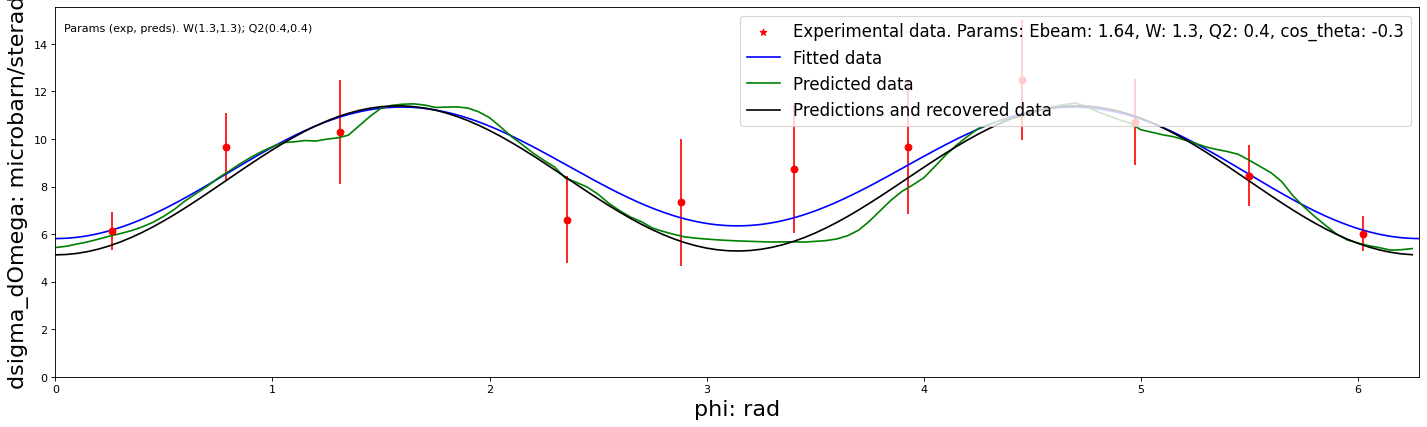

2024-12-03 18:36:46,321 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:46,323 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:46,328 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:46,330 : DEBUG : STREAM b'IDAT' 131 36412
2024-12-03 18:36:46,417 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:46,419 : DEBUG : STREAM b'IDAT' 41 36412


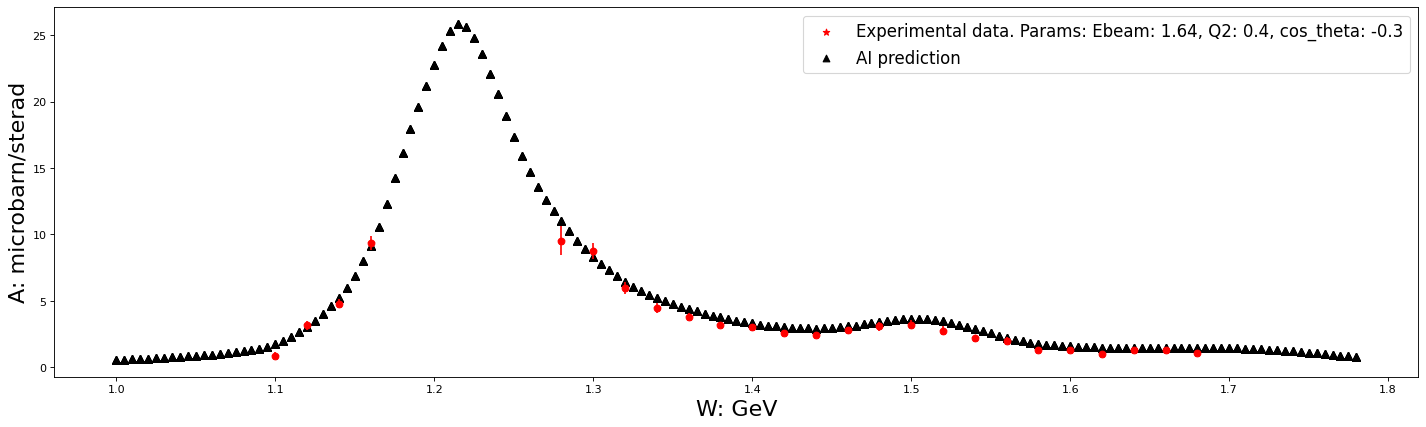

2024-12-03 18:36:47,117 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:47,119 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:47,125 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:47,127 : DEBUG : STREAM b'IDAT' 131 36347
2024-12-03 18:36:47,230 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:47,232 : DEBUG : STREAM b'IDAT' 41 36347


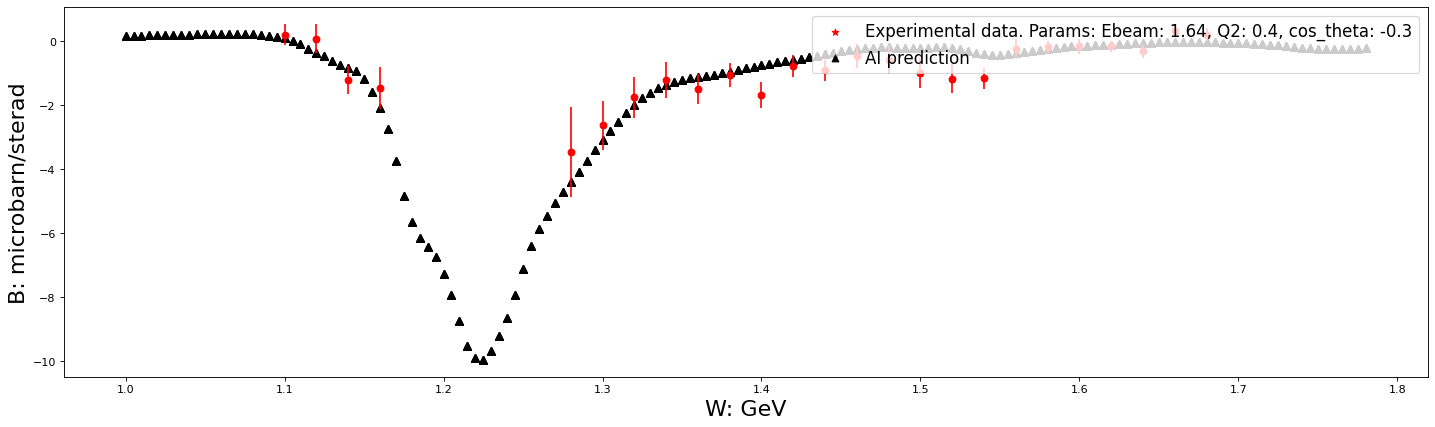

2024-12-03 18:36:47,915 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:47,917 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:47,920 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:47,923 : DEBUG : STREAM b'IDAT' 131 36738
2024-12-03 18:36:48,012 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:48,014 : DEBUG : STREAM b'IDAT' 41 36738


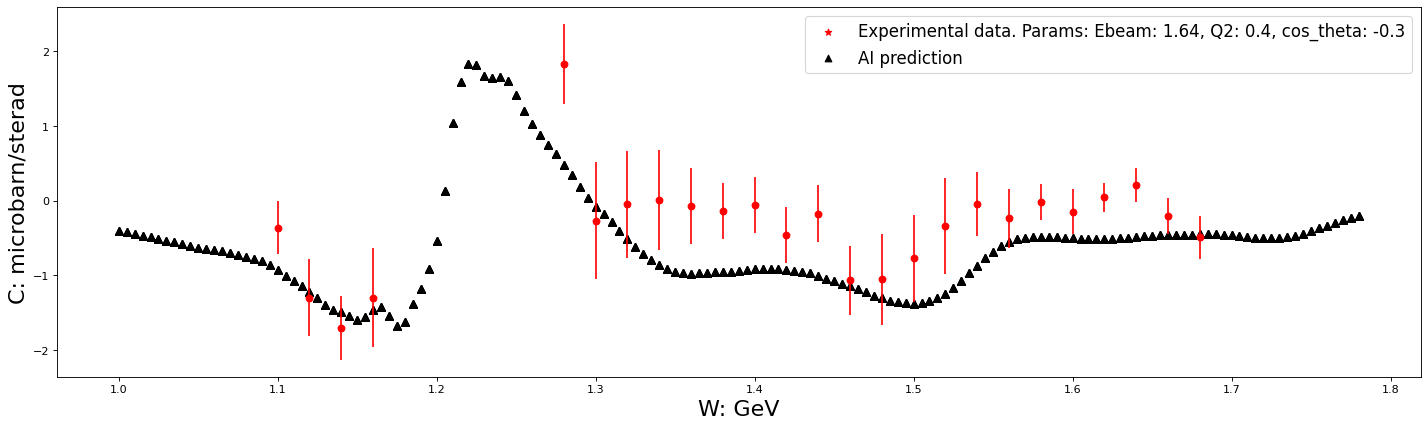

2024-12-03 18:36:48,681 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:48,684 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:48,687 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:48,689 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 18:36:48,786 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:48,788 : DEBUG : STREAM b'IDAT' 41 65536


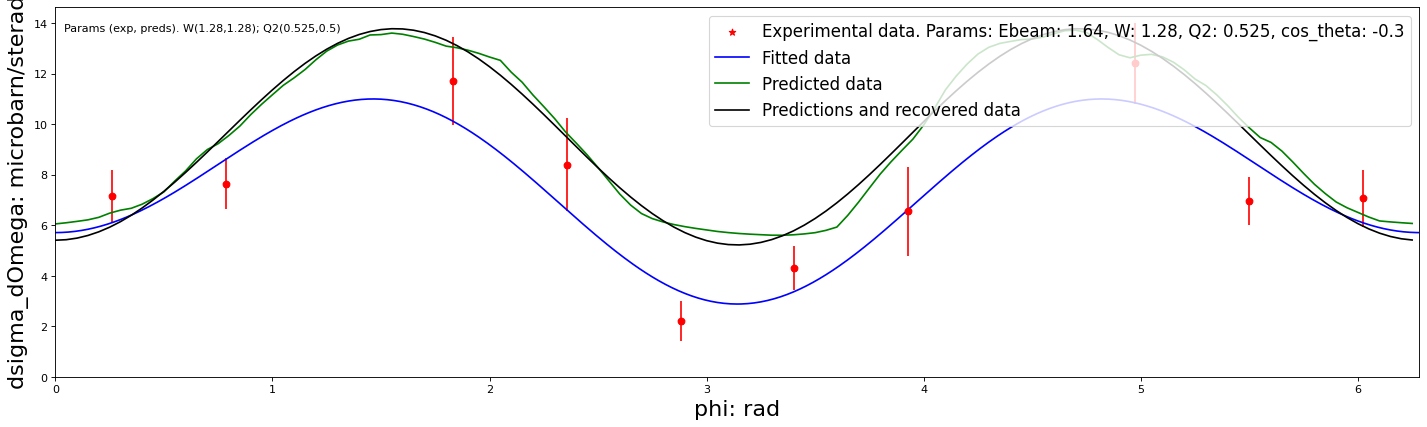

2024-12-03 18:36:49,502 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:49,504 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:49,506 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:49,509 : DEBUG : STREAM b'IDAT' 131 37594
2024-12-03 18:36:49,597 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:49,600 : DEBUG : STREAM b'IDAT' 41 37594


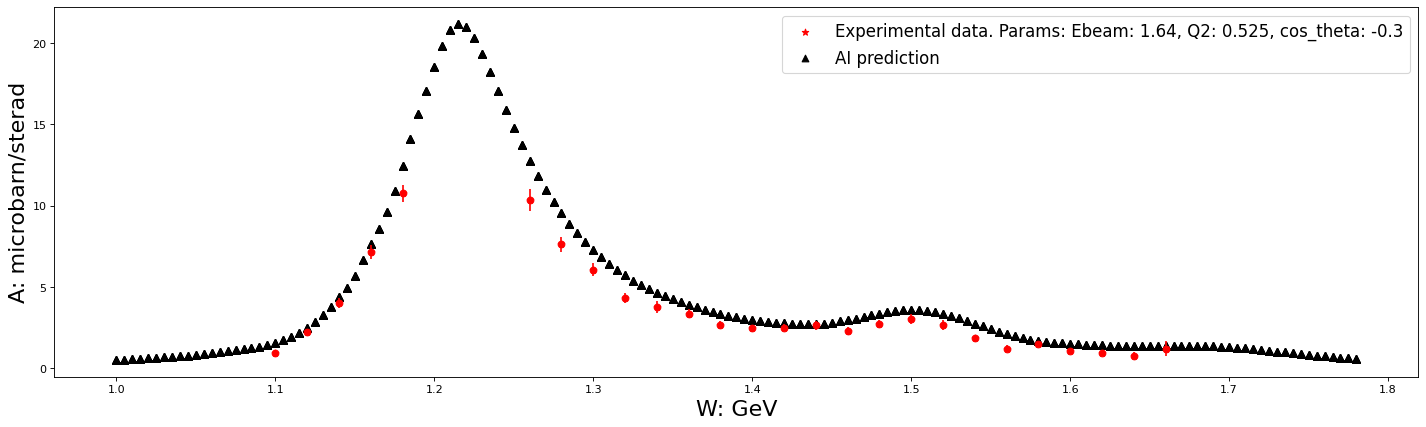

2024-12-03 18:36:50,456 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:50,464 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:50,466 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:50,468 : DEBUG : STREAM b'IDAT' 131 37357
2024-12-03 18:36:50,617 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:50,620 : DEBUG : STREAM b'IDAT' 41 37357


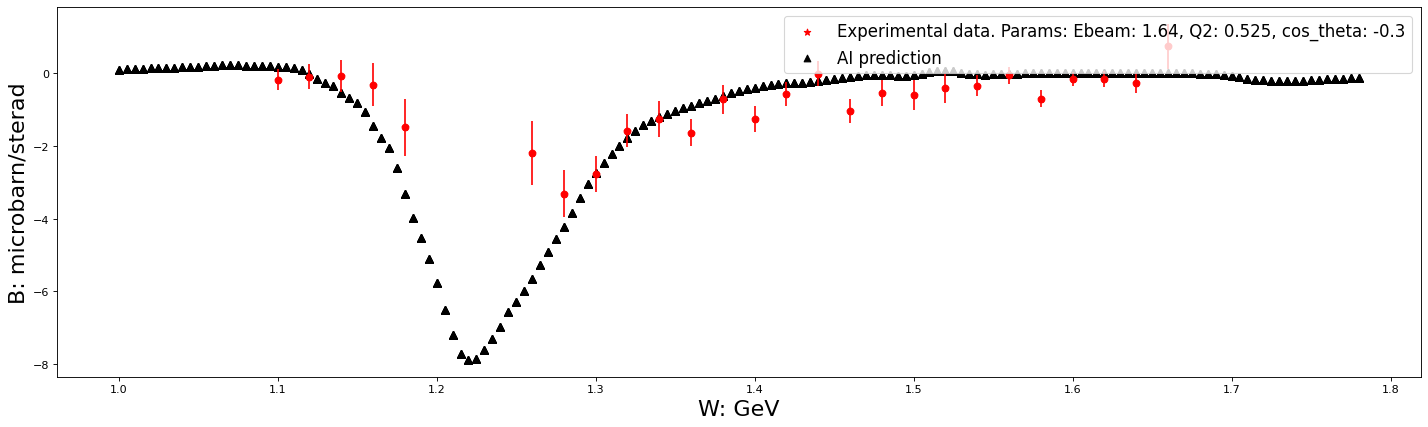

2024-12-03 18:36:51,623 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:51,626 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:36:51,628 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:36:51,630 : DEBUG : STREAM b'IDAT' 131 37474
2024-12-03 18:36:51,759 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:36:51,765 : DEBUG : STREAM b'IDAT' 41 37474


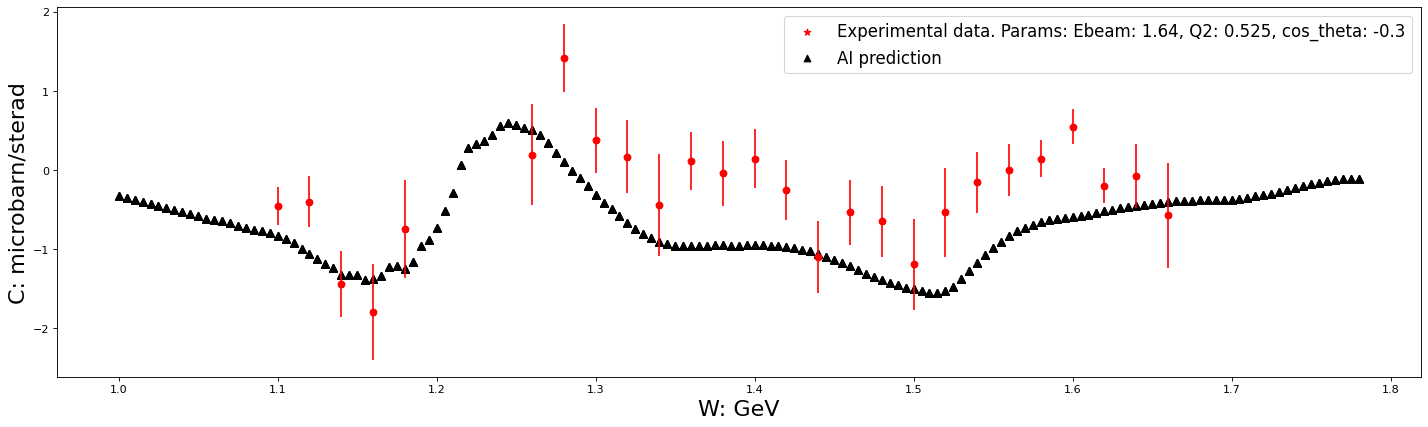

100%|██████████| 157/157 [00:06<00:00, 24.29it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-18-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23974098693253387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-18-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02108924022022198' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inp

2024-12-03 18:50:57,168 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:50:57,171 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:50:57,174 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:50:57,176 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 18:50:57,275 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:50:57,278 : DEBUG : STREAM b'IDAT' 41 65536


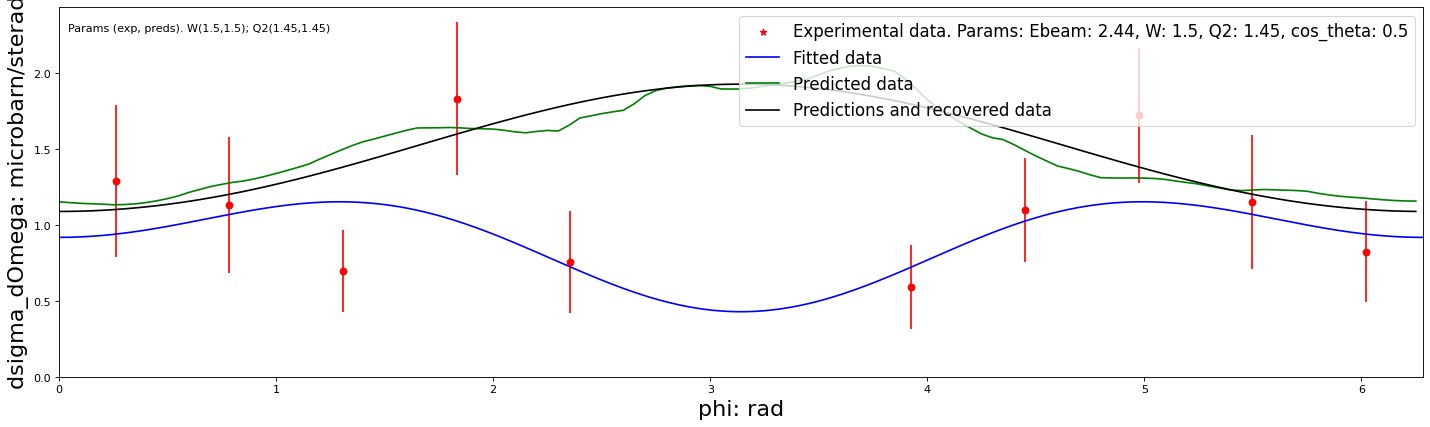

2024-12-03 18:50:58,194 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:50:58,197 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:50:58,200 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:50:58,201 : DEBUG : STREAM b'IDAT' 131 37962
2024-12-03 18:50:58,293 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:50:58,297 : DEBUG : STREAM b'IDAT' 41 37962


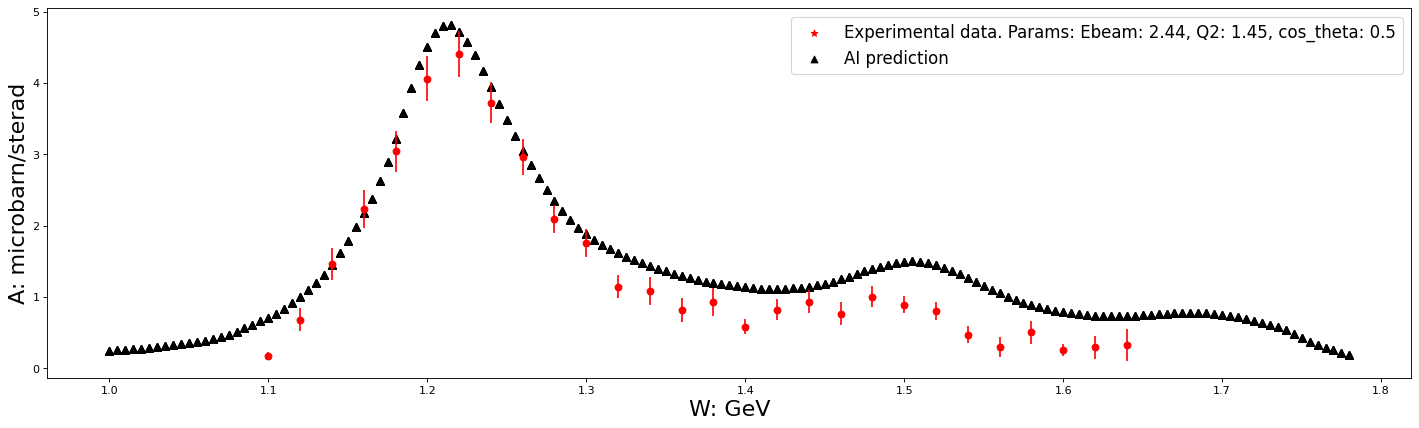

2024-12-03 18:50:59,186 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:50:59,188 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:50:59,193 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:50:59,197 : DEBUG : STREAM b'IDAT' 131 37148
2024-12-03 18:50:59,284 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:50:59,286 : DEBUG : STREAM b'IDAT' 41 37148


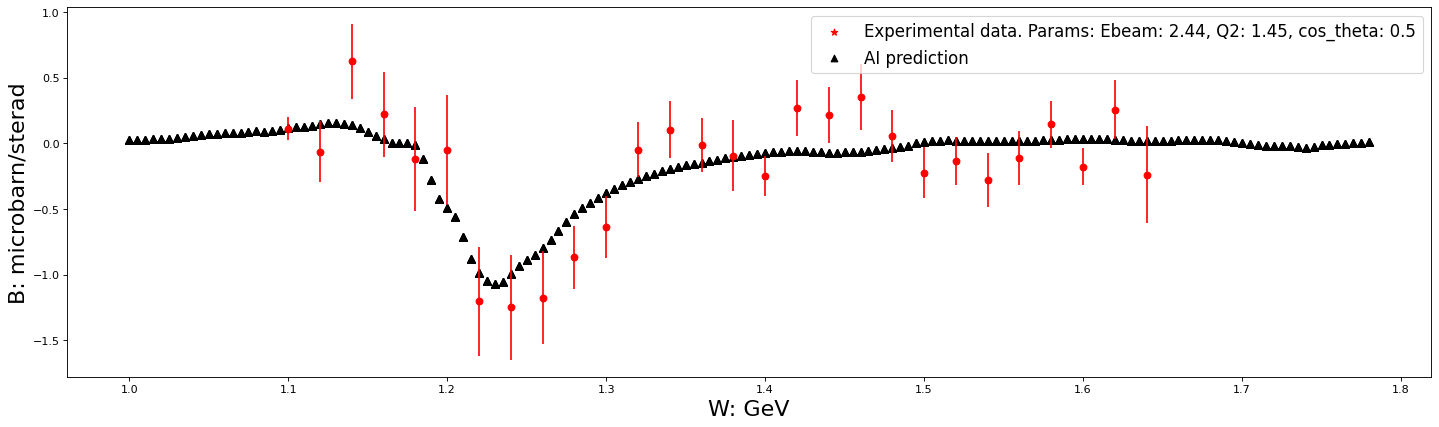

2024-12-03 18:51:00,166 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:00,168 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:51:00,171 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:51:00,173 : DEBUG : STREAM b'IDAT' 131 38067
2024-12-03 18:51:00,262 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:00,267 : DEBUG : STREAM b'IDAT' 41 38067


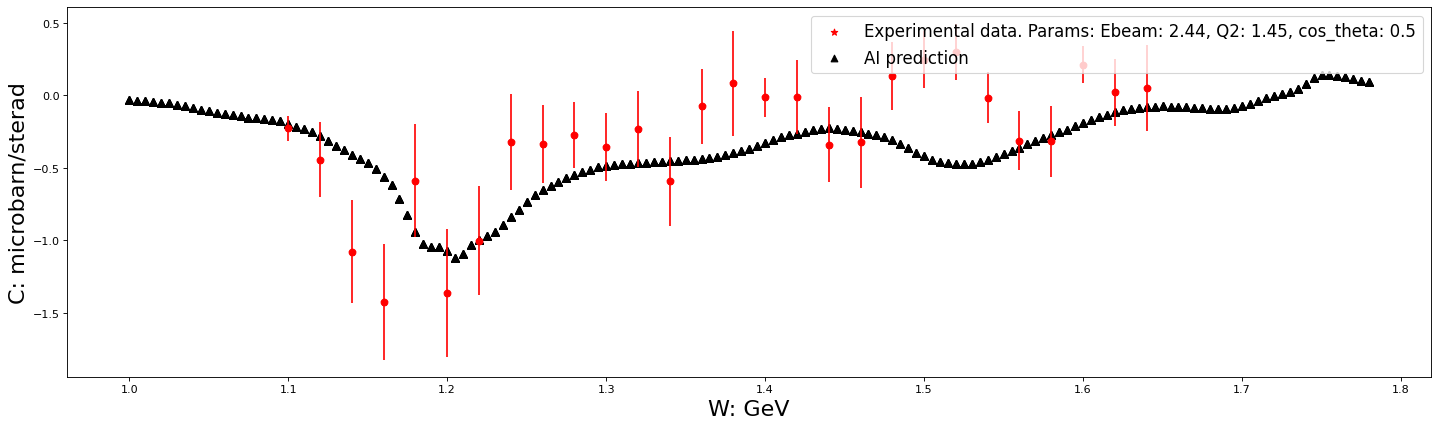

2024-12-03 18:51:01,128 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:01,131 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:51:01,134 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:51:01,138 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 18:51:01,241 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:01,243 : DEBUG : STREAM b'IDAT' 41 65536


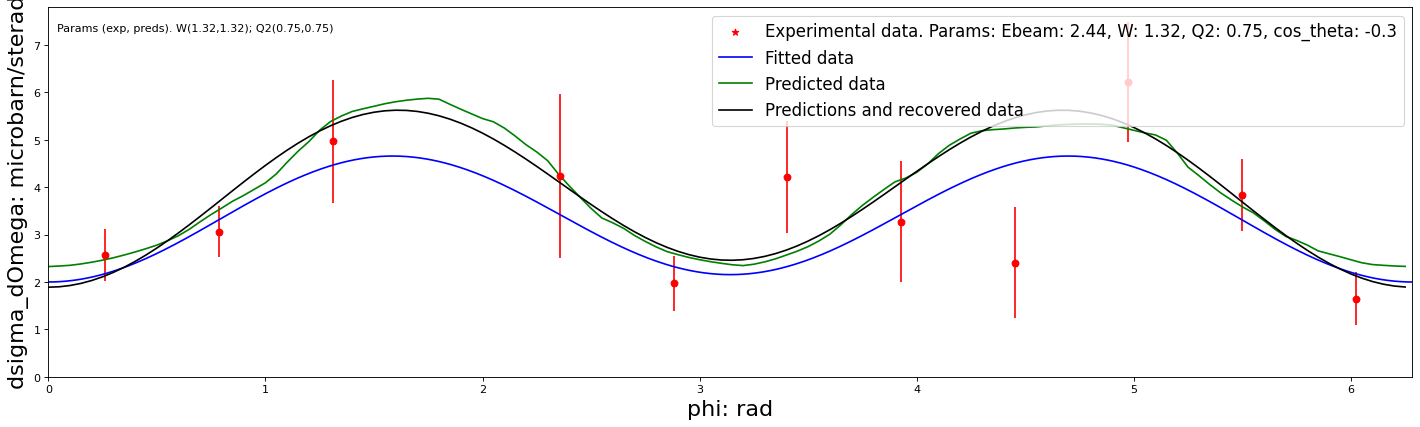

2024-12-03 18:51:02,157 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:02,159 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:51:02,162 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:51:02,168 : DEBUG : STREAM b'IDAT' 131 38500
2024-12-03 18:51:02,263 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:02,265 : DEBUG : STREAM b'IDAT' 41 38500


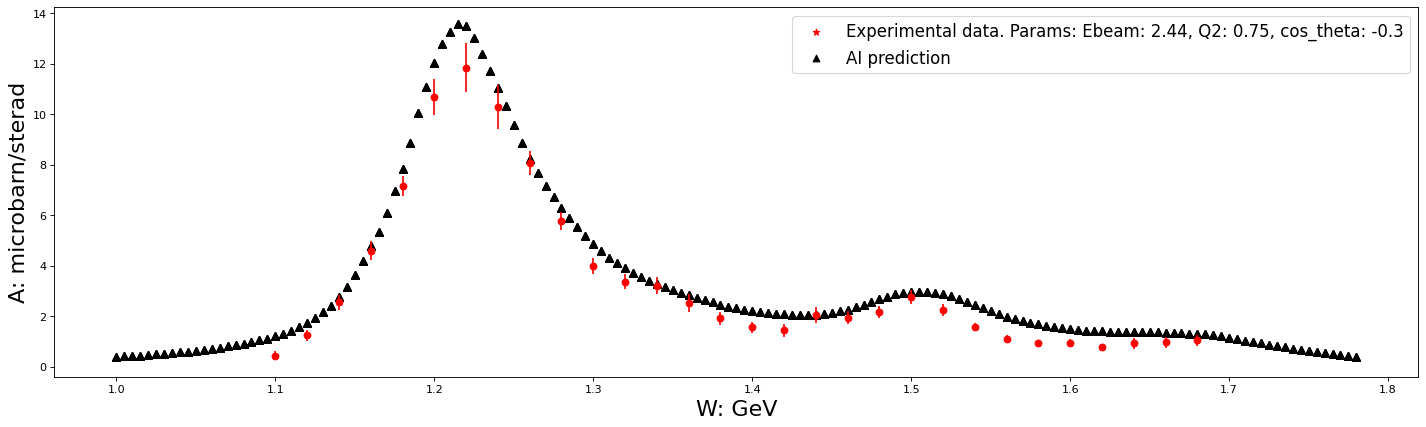

2024-12-03 18:51:03,158 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:03,161 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:51:03,163 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:51:03,165 : DEBUG : STREAM b'IDAT' 131 38317
2024-12-03 18:51:03,262 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:03,264 : DEBUG : STREAM b'IDAT' 41 38317


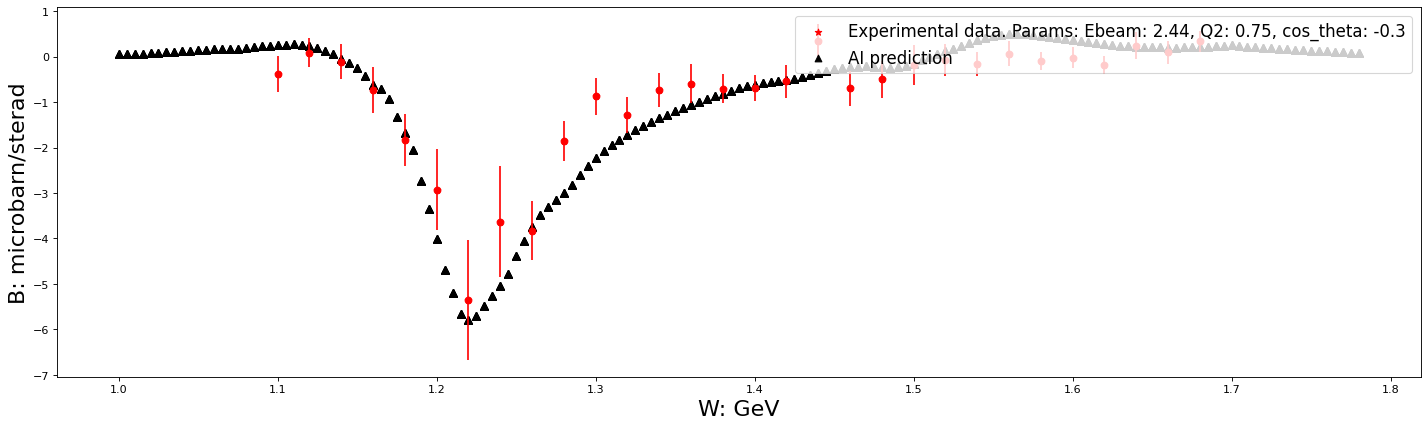

2024-12-03 18:51:04,182 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:04,184 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 18:51:04,187 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 18:51:04,189 : DEBUG : STREAM b'IDAT' 131 39587
2024-12-03 18:51:04,286 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 18:51:04,291 : DEBUG : STREAM b'IDAT' 41 39587


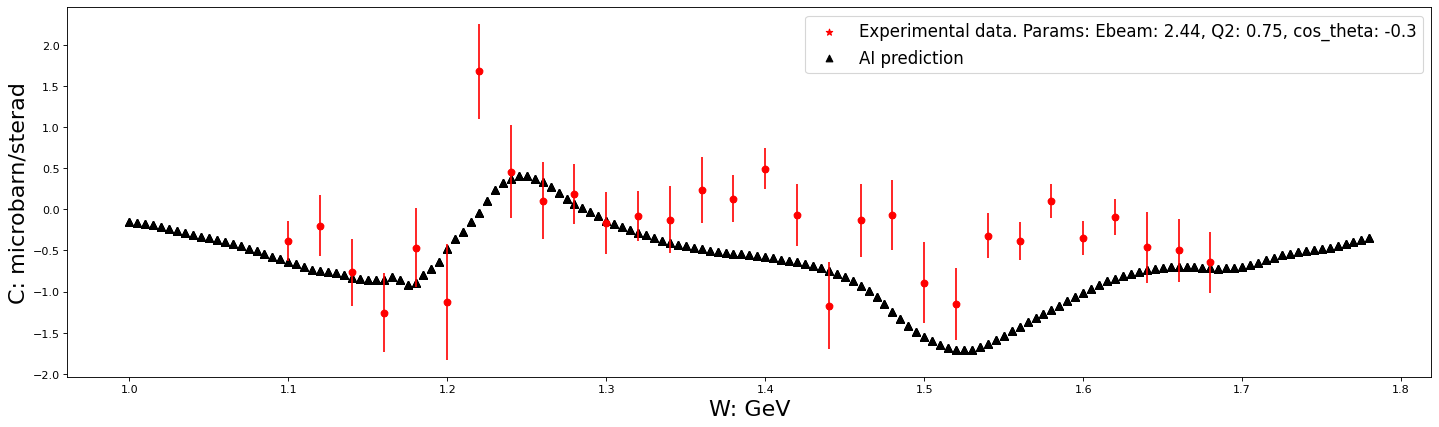

100%|██████████| 97/97 [00:08<00:00, 12.11it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-18-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13818783707801482' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-18-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.017573586473082006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inpu

2024-12-03 19:10:24,591 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:24,593 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:24,596 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:24,598 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 19:10:24,714 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:24,719 : DEBUG : STREAM b'IDAT' 41 65536


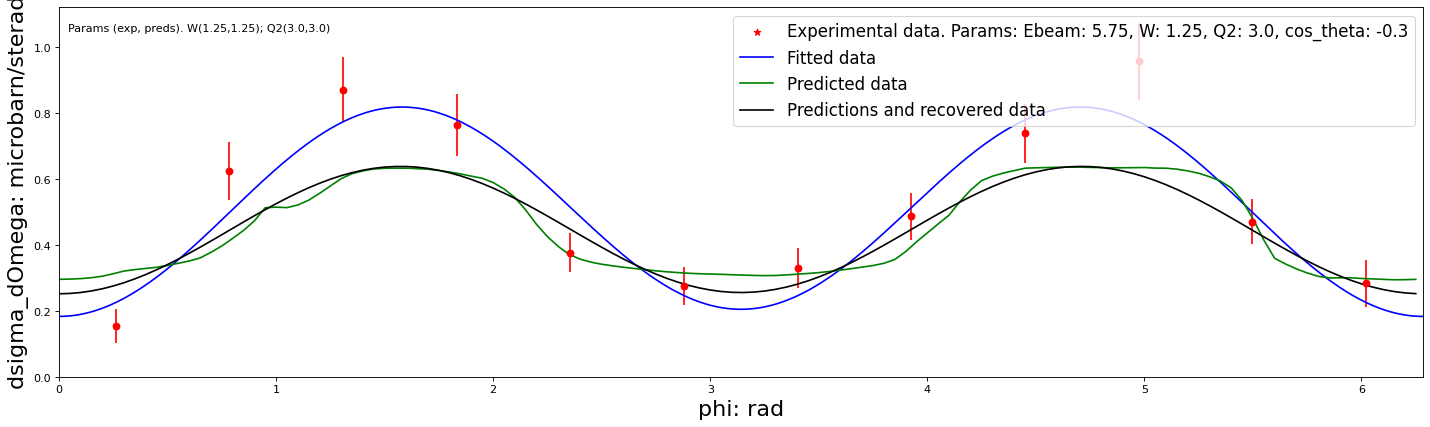

2024-12-03 19:10:26,066 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:26,069 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:26,071 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:26,073 : DEBUG : STREAM b'IDAT' 131 35887
2024-12-03 19:10:26,224 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:26,227 : DEBUG : STREAM b'IDAT' 41 35887


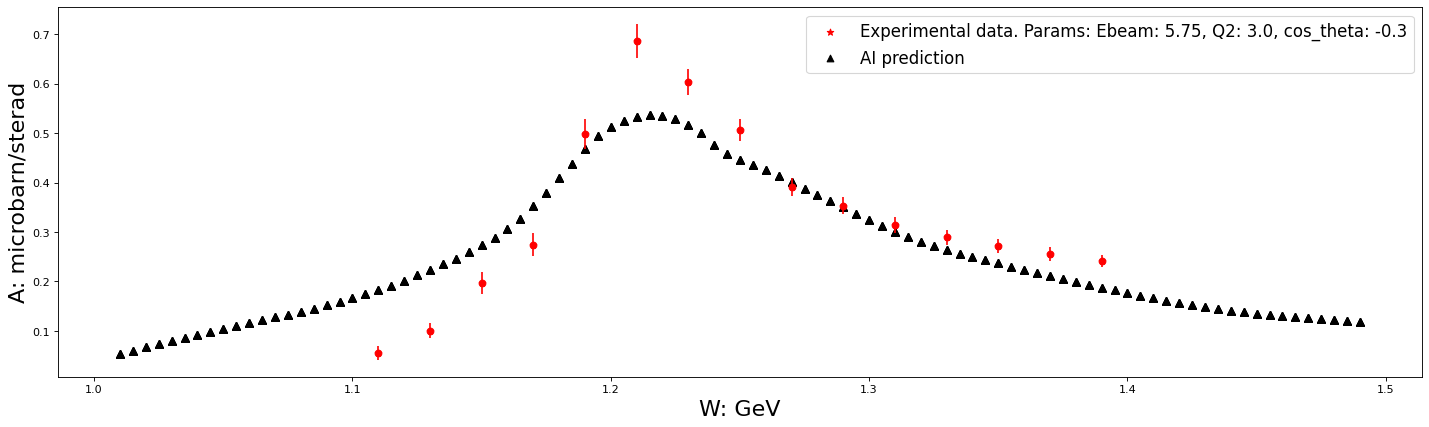

2024-12-03 19:10:27,770 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:27,773 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:27,775 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:27,782 : DEBUG : STREAM b'IDAT' 131 34138
2024-12-03 19:10:27,909 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:27,911 : DEBUG : STREAM b'IDAT' 41 34138


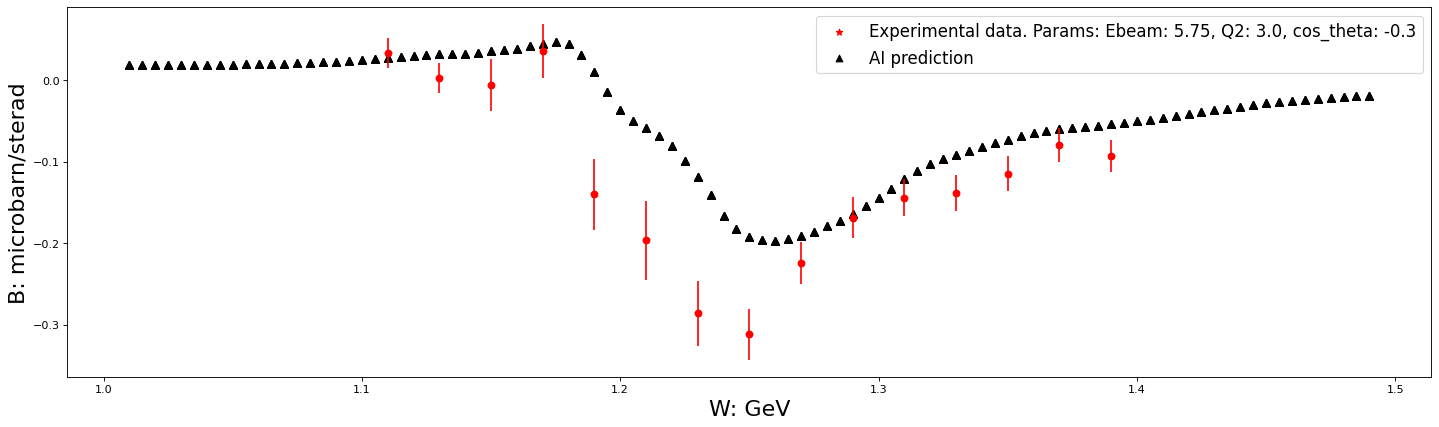

2024-12-03 19:10:28,887 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:28,890 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:28,893 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:28,898 : DEBUG : STREAM b'IDAT' 131 36369
2024-12-03 19:10:28,998 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:29,003 : DEBUG : STREAM b'IDAT' 41 36369


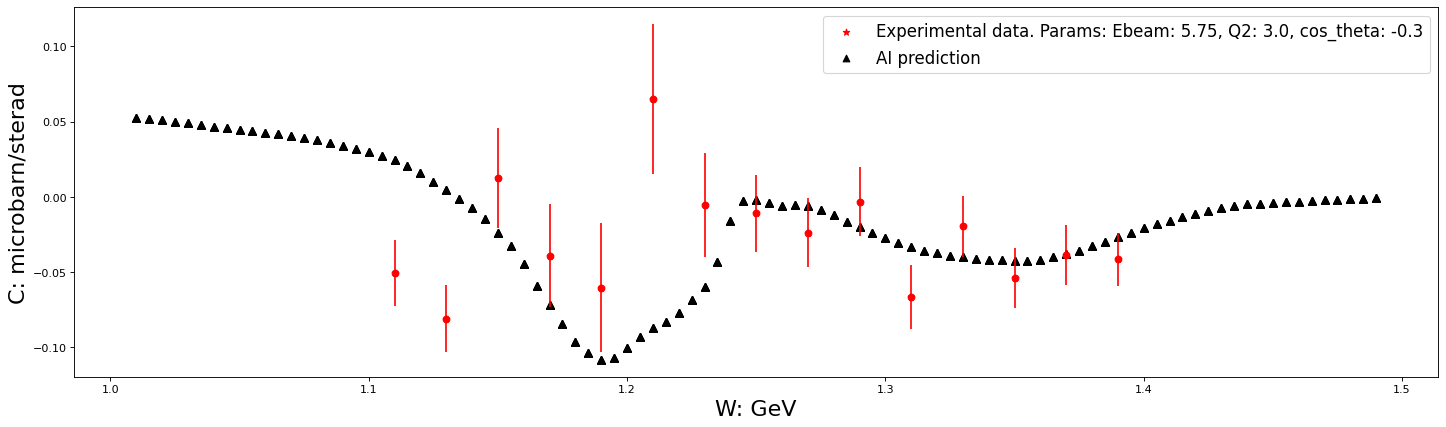

2024-12-03 19:10:30,023 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:30,025 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:30,029 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:30,032 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 19:10:30,145 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:30,150 : DEBUG : STREAM b'IDAT' 41 65536


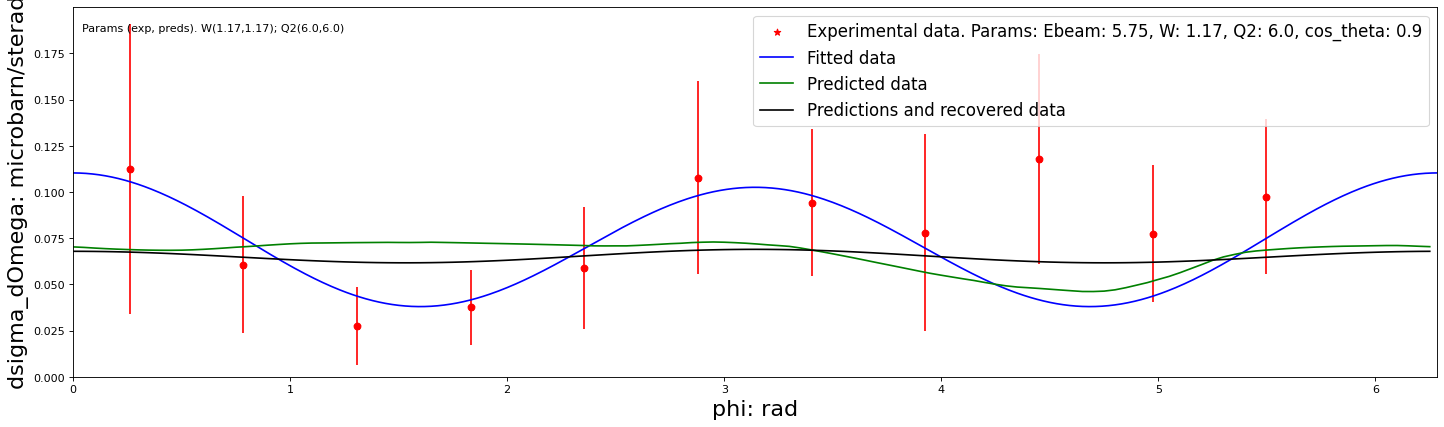

2024-12-03 19:10:31,148 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:31,150 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:31,152 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:31,154 : DEBUG : STREAM b'IDAT' 131 39019
2024-12-03 19:10:31,261 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:31,263 : DEBUG : STREAM b'IDAT' 41 39019


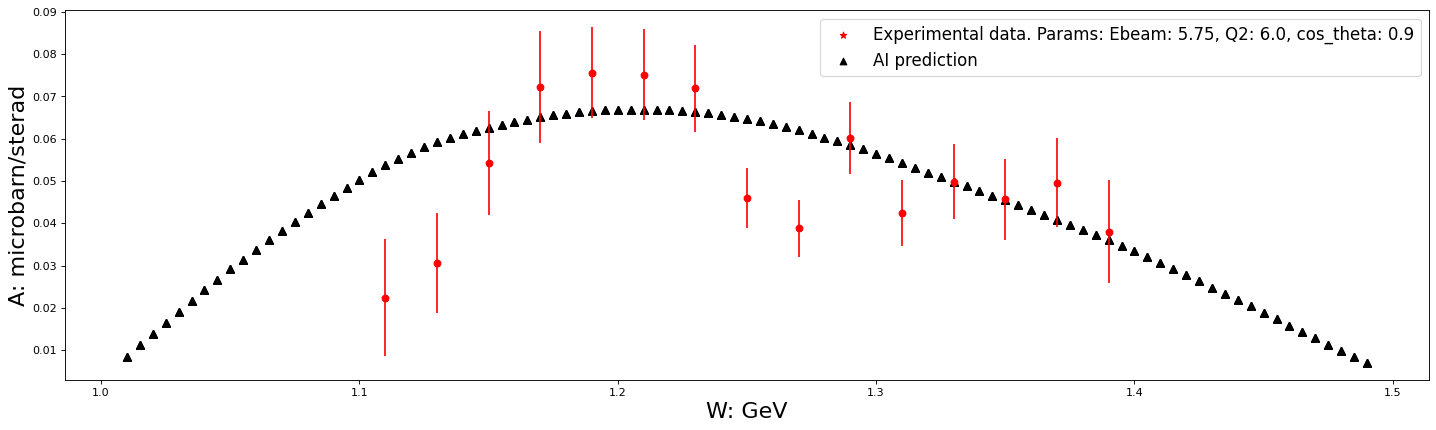

2024-12-03 19:10:32,284 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:32,286 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:32,289 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:32,371 : DEBUG : STREAM b'IDAT' 131 36363
2024-12-03 19:10:32,470 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:32,473 : DEBUG : STREAM b'IDAT' 41 36363


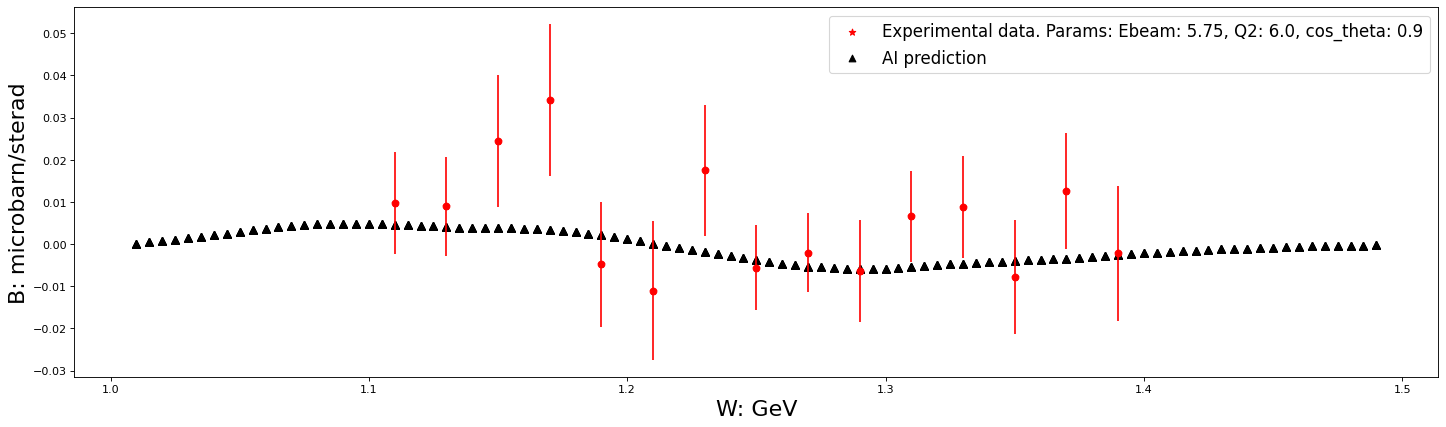

2024-12-03 19:10:33,626 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:33,628 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:10:33,630 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:10:33,632 : DEBUG : STREAM b'IDAT' 131 35927
2024-12-03 19:10:33,739 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:10:33,742 : DEBUG : STREAM b'IDAT' 41 35927


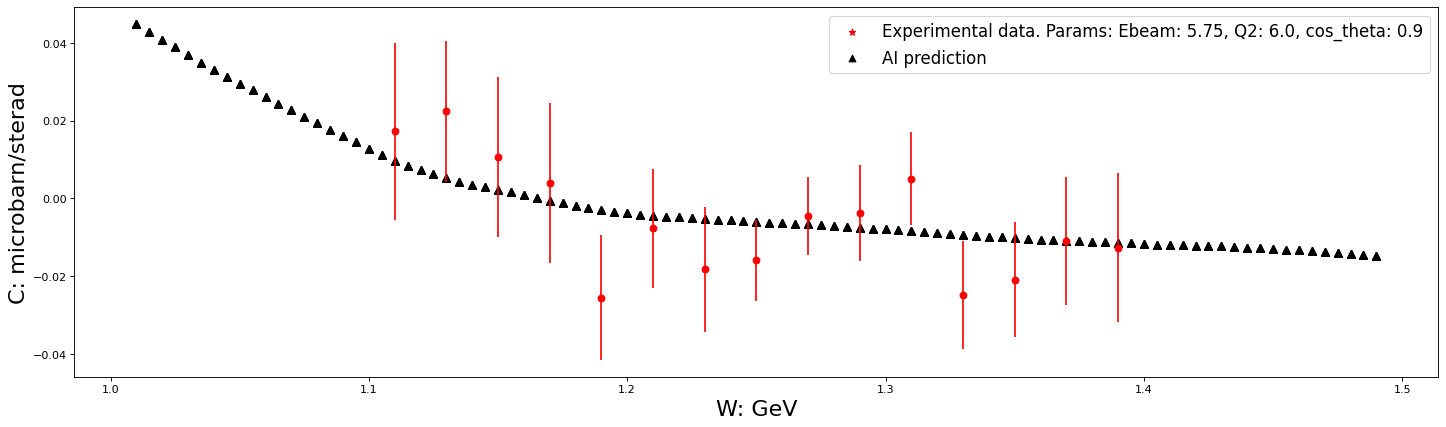

100%|██████████| 177/177 [00:02<00:00, 62.25it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-18-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22805164940499248' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-18-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0024712405024307394' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-

0 2.04 1.3125 0.65 -0.100000512686068
2.04 1.3125 0.65 -0.100000512686068
0 2.04 1.5875 0.65 0.69999995013338
2.04 1.5875 0.65 0.69999995013338
0 2.04 1.4875 0.65 -0.300006607736738
2.04 1.4875 0.65 -0.300006607736738
0 2.04 1.6875 0.55 0.69999995013338
2.04 1.6875 0.55 0.69999995013338
0 2.04 1.2875 0.95 -0.100000512686068
2.04 1.2875 0.95 -0.100000512686068
2024-12-03 19:20:07,990 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:07,992 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:07,995 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:07,997 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 19:20:08,129 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:08,131 : DEBUG : STREAM b'IDAT' 41 65536


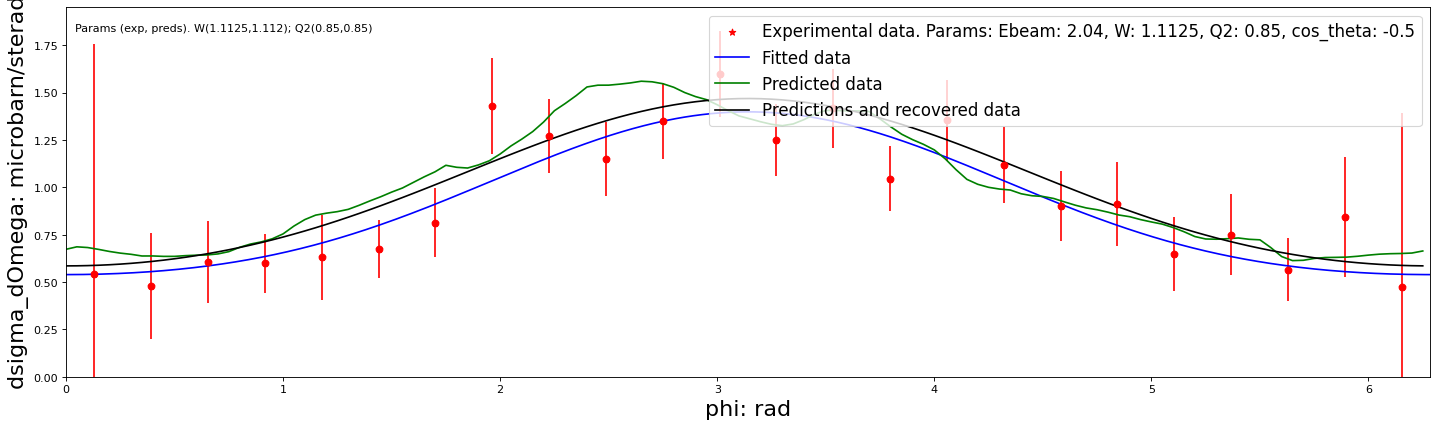

2024-12-03 19:20:08,909 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:08,911 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:08,915 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:08,917 : DEBUG : STREAM b'IDAT' 131 36668
2024-12-03 19:20:09,042 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:09,044 : DEBUG : STREAM b'IDAT' 41 36668


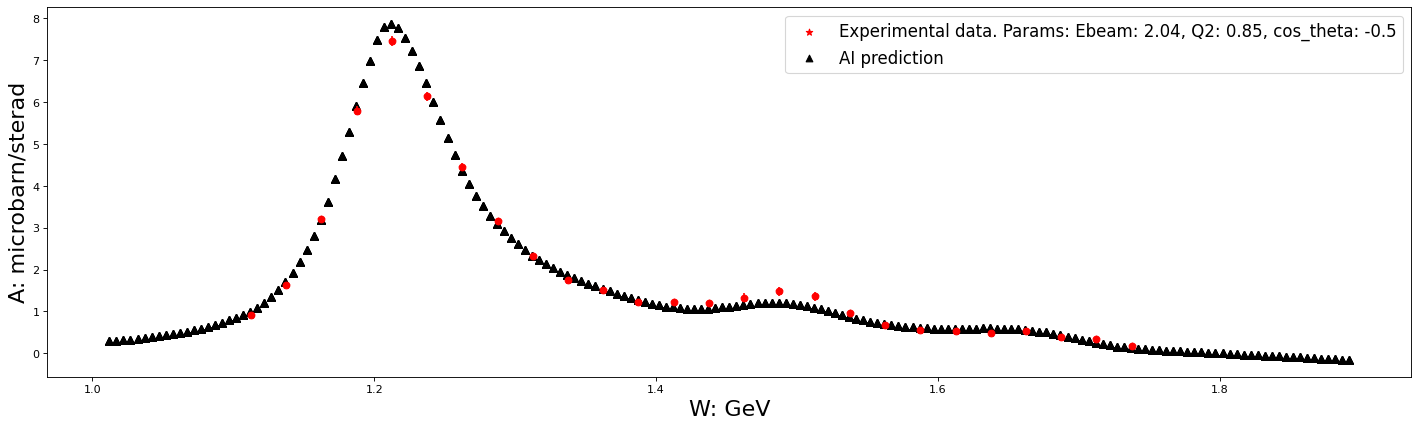

2024-12-03 19:20:09,815 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:09,817 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:09,819 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:09,821 : DEBUG : STREAM b'IDAT' 131 37917
2024-12-03 19:20:09,933 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:09,935 : DEBUG : STREAM b'IDAT' 41 37917


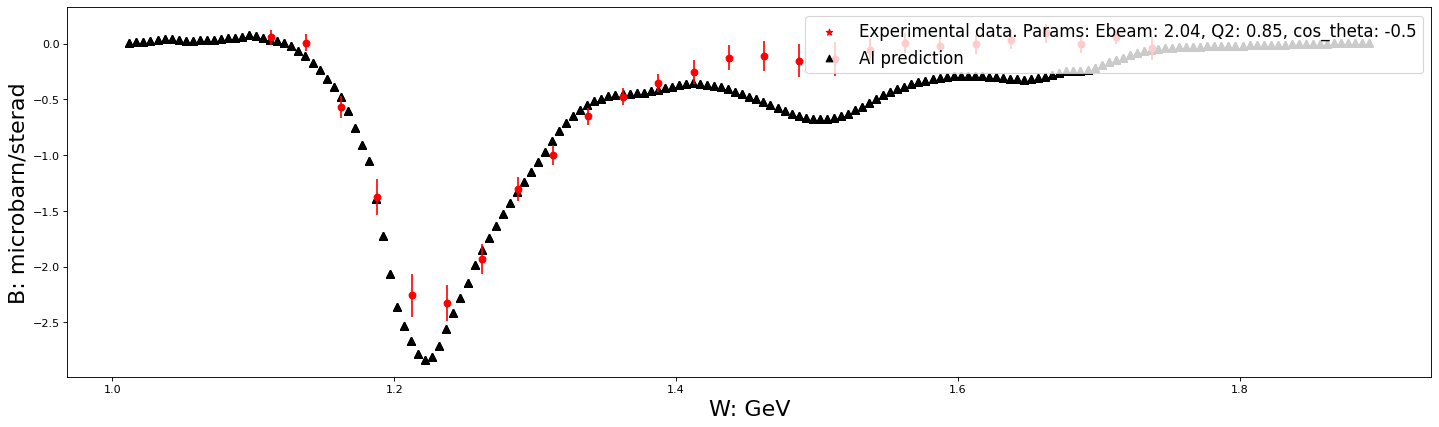

2024-12-03 19:20:10,702 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:10,704 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:10,707 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:10,710 : DEBUG : STREAM b'IDAT' 131 39552
2024-12-03 19:20:10,819 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:10,824 : DEBUG : STREAM b'IDAT' 41 39552


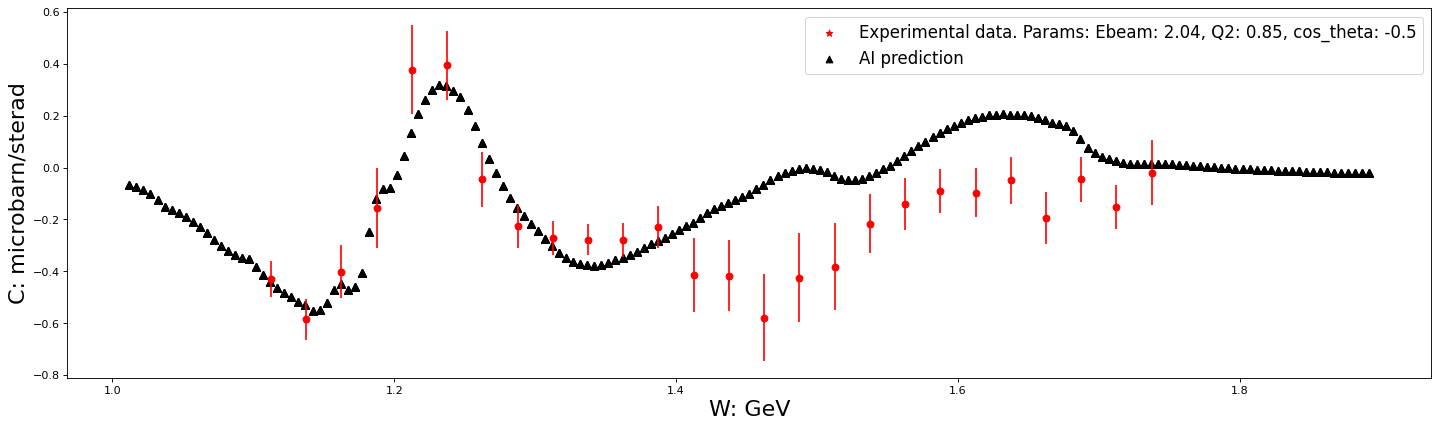

0 2.04 1.4875 0.55 0.100000512686068
2.04 1.4875 0.55 0.100000512686068
0 2.04 1.6875 0.85 -0.899999488480797
2.04 1.6875 0.85 -0.899999488480797
0 2.04 1.3375 0.75 -0.69999995013338
2.04 1.3375 0.75 -0.69999995013338
0 2.04 1.4875 0.75 -0.300006607736738
2.04 1.4875 0.75 -0.300006607736738
0 2.04 1.3125 0.75 -0.899999488480797
2.04 1.3125 0.75 -0.899999488480797
0 2.04 1.5125 0.75 -0.100000512686068
2.04 1.5125 0.75 -0.100000512686068
0 2.04 1.5375 0.55 -0.300006607736738
2.04 1.5375 0.55 -0.300006607736738
2024-12-03 19:20:13,829 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:13,831 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:13,834 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:13,836 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 19:20:13,952 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:13,954 : DEBUG : STREAM b'IDAT' 41 65536


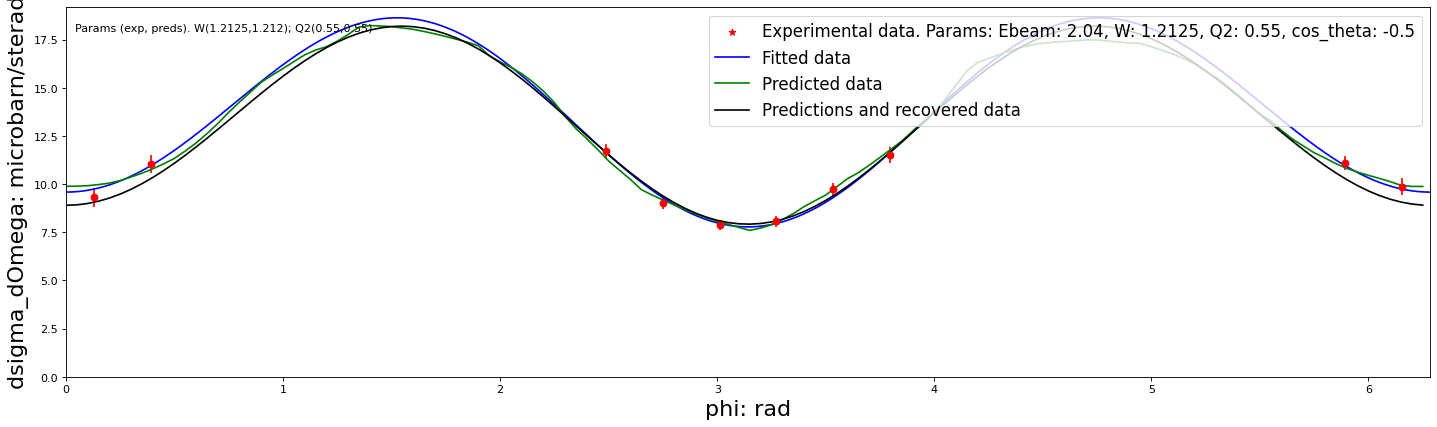

2024-12-03 19:20:14,740 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:14,742 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:14,745 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:14,747 : DEBUG : STREAM b'IDAT' 131 37042
2024-12-03 19:20:14,867 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:14,870 : DEBUG : STREAM b'IDAT' 41 37042


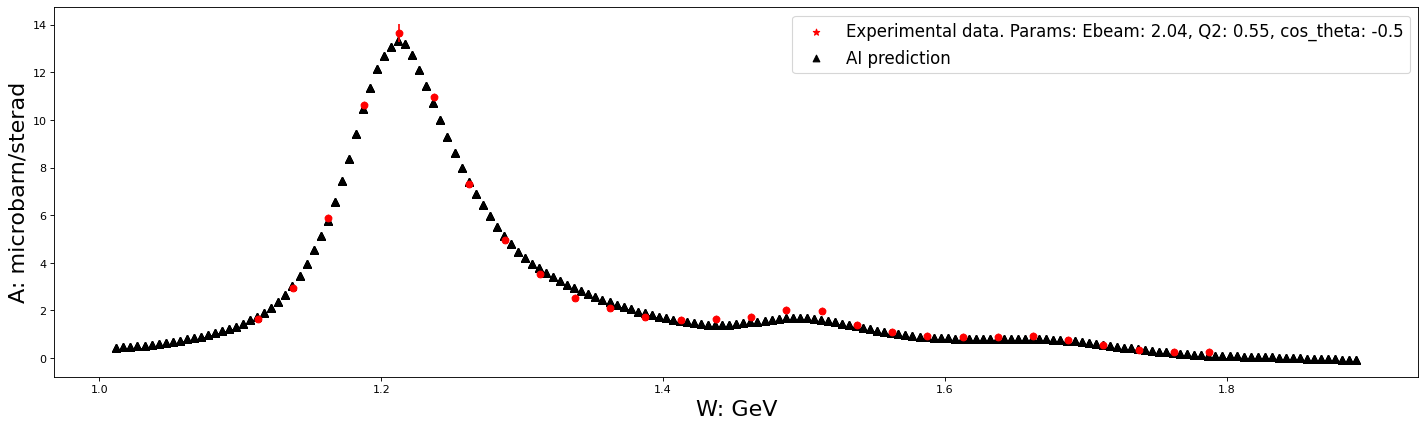

2024-12-03 19:20:15,912 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:15,914 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:15,916 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:15,918 : DEBUG : STREAM b'IDAT' 131 36055
2024-12-03 19:20:16,058 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:16,060 : DEBUG : STREAM b'IDAT' 41 36055


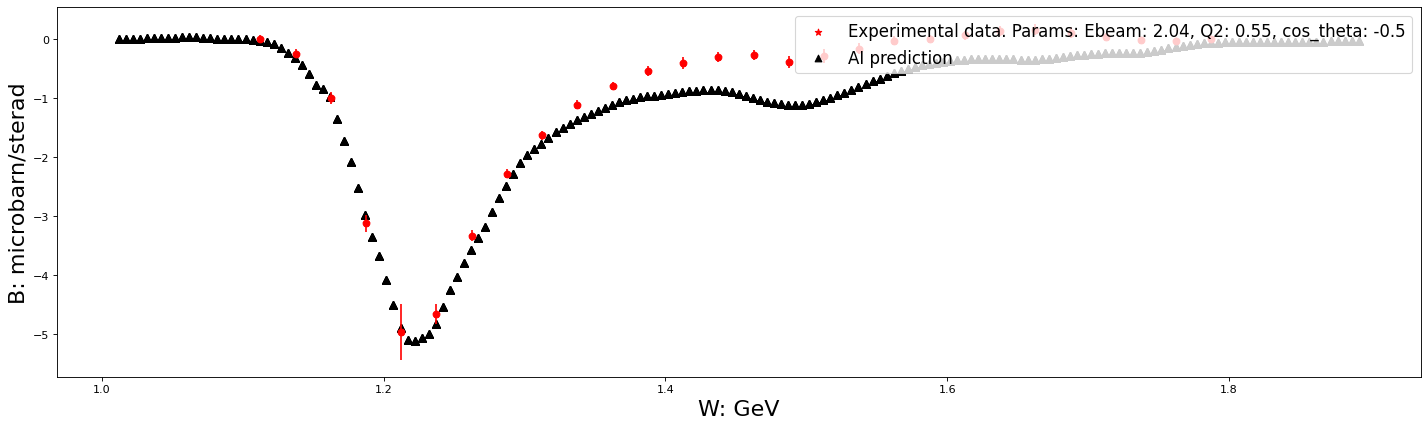

2024-12-03 19:20:17,161 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:17,163 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 19:20:17,166 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 19:20:17,168 : DEBUG : STREAM b'IDAT' 131 37904
2024-12-03 19:20:17,308 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 19:20:17,311 : DEBUG : STREAM b'IDAT' 41 37904


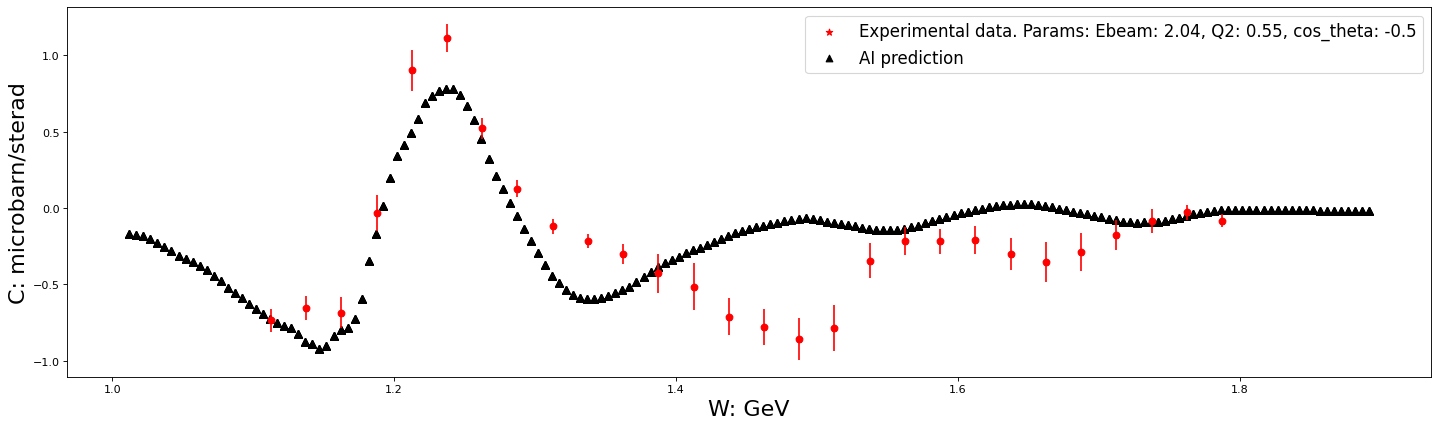

In [19]:
os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)
    step = 0
    while step != 2:
        picture_is_not_drawn = True
        while picture_is_not_drawn:
            Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
            W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
            cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
            try:
                plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
            except:
                print(Ebeam, W, Q2, cos_theta)
            else:
                plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
                plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
                plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
                step += 1
                picture_is_not_drawn = False

In [20]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,██▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇▇███████████████████████████████████
train_rmse,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_loss,█▄▂▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▅▃▄▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
from google.colab import files
!zip -r /content/solar-firefly-2.zip '/content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/solar-firefly-2'
files.download("/content/solar-firefly-2.zip")